# Алгоритмы кластеризации

Я хочу рассказать об одном не очень известном алгоритме кластеризации. 

Как правило, вместе со словом кластеризация у человека, который имеет базовые знания в ML, возникает стойкая ассоциация с одним известным методом [K-means](https://en.wikipedia.org/wiki/K-means_clustering), либо его расширениями и родственниками: [K-means++](https://en.wikipedia.org/wiki/K-means%2B%2B), [K-medians](https://ru.wikipedia.org/wiki/K-medians). А далее может возникнуть неприятное молчание. Оказывается, что сходу может быть сложно назвать какой бы то ни было ещё алгоритм.

Не стоит забывать, что помимо семейства **K-...**, есть замечательный [DBSCAN](https://habrahabr.ru/post/322034/), графовые алгоритмы кластеризации, близкое ему семейство иерархической кластеризации, [Affinity Propagation](https://en.wikipedia.org/wiki/Affinity_propagation), а также многие другие. Относительно полный список можно найти [здесь](https://ru.wikipedia.org/wiki/%D0%9A%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%BD%D1%8B%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7) и [тут](https://logic.pdmi.ras.ru/~sergey/teaching/ml/11-cluster.pdf).

Все эти алгоритмы располагают серьёзной информацией об устройстве мира кластеризуемых объектов. Как минимум, здесь используется мера близости объектов, основанная на векторном представлении. Но что, если... мы ничего не можем сказать об объекте, за исключением того, равны ли они между собой или нет. Замечу, что такие ситуации встречаются катострафически часто:

* **Тексты**. Каждое слово можно сравнивать с каждым другим лишь на равенство. Разумеется, есть расширения этого подхода, но они намного сложнее концептуально.
* **Даты**. Например, дни недели часто удобно рассматривать как категории. Хотя, если копнуть глубже, то, разумеется, здесь есть все признаки частичного порядка и ранговой шкалы.
* **Географические объекты**. Названия сёл, городов, стран и др.
* **Категории в узком смысле**. Категории товаров в магазине; маркетенговые сегменты в банке; симптомы заболеваний у пациента и т.д.
* **Количественные шкалы, преобразованные в номинальные**. Иногда вещественные признаки градуируют и переводят в ранговые и номинальные, после чего работают уже с ними.
* **Id** объектов. Часто можно встретить в данных уже заданные отношения. Такое происходит, например, в социальных сетях. У людей есть наборы друзей, которые задаются при помощи *id*. Это представляется в виде *человек i* -> [друг 1, друг 2, ..., друг n_i]. На множестве *id* также задано отношения равенства. А значит это категориальный признак.
* ...

Для признаков, которые получаются из вышеуказанных объектов, задано только отношение эквивалентности, т.е. пары вида: 

$(a, b) = \{(a, b) \in \text{X}^2|a=b\}$

Об алгоритме, который работает с такими объектами и пойдёт речь ниже.

# CLOPE. Описание

В [оригинальной статье](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.13.7142&rep=rep1&type=pdf) наборы категориальных признаков различной мощности (размера), называются **Transactional Data**. Работы с данными высокой размерности, как правило, предполагает их продолжительную обработку. Авторы статьи предлагают довольно шустрый алгоритм для таких целей.

Задача перед **CLOPE** стоит простая: необходимо разделить набор транзакций на поднаборы. Но как это сделать? Нужно выбрать какой-нибудь адекватный критерий.

Перед тем, как продолжить и ввести критерий, рассмотрим пример.

### Пример

Пусть у нас есть 5 транзакций. Для простоты, под транзакциями можно мыслить корзину покупок, которую делали пользователи в интернет-магазине. Рассмотрим 5 транзакций:

$\{\text{(яблоко, банан), (яблоко, банан, пирожоное), (яблоко, пирожоное, тарелка), (тарелка, утка), (тарелка, утка, рыба)}\} = \{\text{(я, б), (я, б, п), (я, п, т), (т, у), (т, у, р)}\} = \{\text{яб, ябп, япт, ту, тур}\}$

Как-нибудь разобьём наши транзакции двумя способами, предварительно отсортировав:

Разбиение 1: $\{\{\text{яб, ябп, япт}\}, \{\text{ту, тур}\}\}$

Разбиение 2: $\{\{\text{яб, ябп}\}, \{\text{япт, ту, тур}\}\}$

Теперь нужно научиться как-то сравнивать разбиения. Интуитивно понятно, что чем больше общих элементов в разбиении, тем лучше. Авторы алгоритма предложили элегантный способ сравнения таких объектов. Построим частотную гистограмму признаков, которые входят в каждый кластер:

<img src="../../img/histogram.png">

Качество двух разбиений оценим, проанализировав их высоту $H$ и ширину $W$. Под $W$ будем понимать количество различных признаков. Кластеры $\text{{ту, тур}}$ и $\text{{яб, ябп}}$ имеют одинаковые гистограммы, следовательно, равноценны. Гистограмма для кластера $\text{{яб, ябп, япт}}$ содержит 4 различных элемента и имеет площадь 8 блоков ($H=2, \dfrac{H}{W}=0.5$), а кластер $\text{{япт, ту, тур}}$ – 5 различных элементов с такой же площадью ($H=1.6, \dfrac{H}{W}=0.32$). Очевидно, что разбиение 1 лучше, поскольку обеспечивает большее наложение транзакций друг на друга (соответственно, параметр $H$ там выше).

Вообще говоря, высоту гистограммы вычислить точно нельзя, поэтому она заменяется на "усреднённое" значение. 

Как можно догадаться учитывать только высоту -- слишком плохо. В таком случае теряется "обобщающая способность". Это лего понять, если рассмотреть пример. Пусть есть 2 разбиения:

$\text{{абв, где}}$ 

и

$\text{{{абв}, {где}}}$

т.е. в одном случае имеем 2 кластера, в каждом из которых по 3 объекта. В ином случае имеем 1 кластер, в котором есть 6 объектов. Рассматривая только высоту, заключим, что она равна 1. В таком случае, разбиения не отличаются.

С другой стороны, с точки зрения логики, второе разбиение, в некотором смысле, "эффективнее", поскольку у первой и второй транзакции нет общих элементов, а значит они полностью отличны. В таком случае логичнее отнести их в разные кластеры. Чтобы обеспечить такую эффективность, вводят "штраф", который представляет собой деление высоты на ширину кластера. Т.е. мы хотим обеспечить минимальный разброс внутри каждой совокупности транзакций. 

Таким образом, чем меньше ширина, тем лучше. Чем больше высота, тем лучше. Получаем:

$\text{G(C)} = \dfrac{H}{W} = \dfrac{\frac{S}{W}}{W} = \dfrac{S}{W^2}$

На основе такой очевидной и простой идеи геометрических гистограмм и работает алгоритм CLOPE (англ.: Clustering with sLOPE). Рассмотрим его подробнее в более формальном описании.

Для параметризации алгоритма, предлагается степень в знаменателе заменить на $r$:

$\text{G(C, r)} = \dfrac{S}{W^{r}}$

Таким образом можно получить различное число кластеров. Интерпретация у параметра очень проста - это степень отталкивания. Чем больше $r$, тем дальше разлетаются кластеры. Чем меньше, тем сильнее они притягиваются.

Вместо корзин покупок можно положить тексты (одна транзакция -- один текст), наборы признаков (например, дни недели, месяцы, год и список приобретённых товаров).

### Формальное описание алгоритма

Пусть имеется база транзакций $X$, состоящая из множества транзакций $\{t_1, t_2, \cdots, t_n\}$. Каждая транзакция есть набор объектов $(q_1,\cdots,q_m)$, где под $()$ подразумевается неупорядоченный набор с повторениями. Множество кластеров $\{C_1,\cdots,C_k\}$ - есть разбиение множества $\{t_1,\cdots,t_n\}$, такое, что $C_i \neq \emptyset \land C_i\cap C_j = \emptyset$, для $1 \leq i, j \leq k$. Каждый элемент $C_i$ называется кластером, $n, m, k$ – количество транзакций, количество объектов в базе транзакций и число кластеров соответственно.

$D(C)$ – множество уникальных объектов в $C$;

$Occ(y,C)$ – количество вхождений объекта $y$ в кластер $C$ (частота или высота отдельно взятого столбца гистограммы $С$);

$S(C)= \sum_{y \in D(C)} Occ(y,C)=\sum_{t_i\in C} |t_i|$ – площадь гистограммы или количество объектов в кластере;

$W(C) = |D(C)|$ – ширина гистограммы или количество уникальных объектов в кластере;

$H(C) = \dfrac{S(C)}{W(C)}$ – средняя высота гистограммы;

$G(C, r) = \dfrac{S(C)}{W^r(C)}$ – целевая функция.

Чтобы получить функцию для оценки качества разбиеия, положим:

$\text{Profit}(\mathbb{C}, r) = \dfrac{\sum_{C_k \in \mathbb{C}}G(C_k)|C_k|}{\sum_{C_k \in \mathbb{C}}|C_k|} = 
\dfrac{\sum_{C_k \in \mathbb{C}}\dfrac{H(C)}{W^2(C)}|C_k|}{\sum_{C_k \in \mathbb{C}}|C_k|}$,

где $\mathbb{C}$ -- множество всех кластеров, $|C_k|$ -- мощность кластера в транзакциях.

Умея вычислять качество разбиения $\text{Profit}(\mathbb{C})$, при получении нового объекта можем пытаться отнести его к одному из имеющихся кластеров, либо в новый кластер. В результате этого можно легко вычислить приращение $\Delta\text{Profit}(\mathbb{C})$ после попытки добавить новую транзакцию в один из имеющихся кластеров, либо в новый кластер. В тот кластер, где изменение $\Delta\text{Profit}(\mathbb{C})$ доставит наилучшее значение, следует добавить поступившую транзакцию.

Запишем формулу для вычисления изменения $\Delta\text{Profit}(\mathbb{C})$ при условии, что новая транзакция была добавлена в кластер $p$. Наблюдая за функцией  приращения, можно заметить, что добавляя транзакции в различные кластеры, будет меняться лишь числитель. Поэтому вычислять следует только его. Для вычисления изменения необходимо знать всего одно слагаемое из суммы, посколько все остальные сокращаются при вычитании:

$\Delta\text{Profit}(\mathbb{C}) = \text{Profit}(\mathbb{C_{new}}) - \text{Profit}(\mathbb{C_{old}})$

Таким образом, вычислим:

$\Delta\text{Profit}(\mathbb{C}) = \dfrac{S_{new}(C_p)}{W_{new}^2(C_p)}(|C_p| + 1) - \dfrac{S(C)}{W^2(C)}|C_p|$,

где $S_{new}(C_p), W_{new}(C_p)$ - величины с добавленой новой транзакцией.

Последовательно будем перебирать все транзакции и пытаться добавить каждую в какой-нибудь кластер так, чтобы $Profit$ был максимальным, пока все транзакции не закончатся. Как только все транзакции закончатся, следует перебрать их ещё раз и пытаться переложить каждую транзакцию в другой кластер, так, чтобы $Profit$ увеличился. Так будем делать до тех пор, пока транзакции можно будет переложить.

Далее под под объектами могут пониматься очень разные вещи: слова в тексте, значения признаков некоторого объекта и т.д. Транзакции могут оказываеться также очень различными. Это не должно вводить читателя в заблуждение.

### Вычисления для примера выше

Проведём вычисления для примера выше. Рассмотрим разбиение 1, кластер 1:

$C = \{яб, ябп, япт\}$

Уникальные объекты:

$D(C)=D(\{яб, ябп, япт\}) = \{я, п, б, т\}$

Ширина гистограммы:

$W(C) = |D(C)| = |\{я, п, б, т\}| = 4$

Частоты:

$Occ(я,C)=3$

$Occ(б,C)=2$

$Occ(п,C)=2$

$Occ(т,C)=1$

Площадь:

$S(C)=Occ(я,C)+Occ(б,C)+Occ(п,C)+Occ(т,C)=3+2+2+1=8$

Средняя высота:

$H(C)=\dfrac{S(C)}{W(C)}=\dfrac{8}{4}=2$

Целевая функция для отдельно взятого кластера:

$G(C, 2)=\dfrac{S(C)}{W^2(C)}=0.5$

### Пример с добавлением нового объекта

Задим транзакции, как это сделано в примере выше:

$\{\text{яб, ябп, япт, ту, тур}\}$

Будем последовательно перебирать их и добавлять в кластеры. Изначально считаем, что у нас в наличии есть один пустой кластер. При добавлении транзакции в пустой кластер, создадим ещё один пустой. Проделаем несколько шагов. 

**Обрабатываем $\text{{яб}}$**

*Шаг 1*

Возьмём $\text{{яб}}$ и попытаемся добавить в пустой кластер $C_0$. Посчитаем характеристики:

$Occ(я,C_0)=1$

$Occ(б,C_0)=1$

$D(C_0)=D(\{яб\}) = \{я, б\}$

$W(C_0)=|D(C_0)|=|\{я,б\}| = 2$

$S(C_0)=Occ(я,C_0)+Occ(б,C_0)=1+1=2$

$H(C_0)=\dfrac{S(C_0)}{W(C_0)}=\dfrac{8}{4}=1$

$G(C_0, 2)=\dfrac{S}{W^2}=0.5$

$\Delta\text{Profit}(\mathbb{C_0}) = G_{new}(|C_0| + 1) - G|C_0| = 0.5$

Других кластеров нет. Зафиксируем все вычисленные значения.

*Шаг 2*

Возьмём $\text{{ябп}}$ и попытаемся добавить в кластер $C_0$. Посчитаем характеристики:

$D(C_0)=\{я, б, п\}$

$W(C_0)=|\{я,б,п\}|=3$

$S(C_0)=Occ(я,C_0)+Occ(б,C_0)+Occ(п,C_0)=2+2+1=5$

$H(C_0)=\dfrac{S}{W}=\dfrac{5}{3}$

$G(C_0, 2)=\dfrac{S}{W^2}=\dfrac{5}{9}$

$\Delta\text{Profit}(\mathbb{C_0}) = G_{new}(|C_0| + 1) - G|C_0| = 2\dfrac{5}{9}-\dfrac{1}{2}=\dfrac{11}{18}$

Создадим пустой кластер $C_1$ и добавим транзакцию туда. Посчитаем характеристики:

$D(C_1)=\{я, б, п\}$

$W(C_1)=|\{я,б,п\}|=3$

$S(C_1)=Occ(я,C_1)+Occ(б,C_1)+Occ(п,C_1)=1+1+1=3$

$H(C_1)=\dfrac{S}{W}=1$

$G(C_1, 2)=\dfrac{S}{W^2}=\dfrac{1}{3}$

$\Delta\text{Profit}(\mathbb{C_0})=\dfrac{1}{3}$

Так как прирост при добавлении в $C_0$ больше. Поэтому транзакция будет добавлена туда.

И так далее...

# CLOPE. Алгоритм

Напишем псевдокод алгоритма. Для начала, инициализируем все кластеры, пройдя по всем транзакциям и попытавшись добавить каждую в один из кластеров:

    transactions := все имеющиеся транзакции
    clusters = []
    
    for transact in transactions:
        max_gradient = -Inf
        best_cluster = None
        
        for cluster in clusters:
            gradient = cluster.append(transact).get_gradient() - cluster.get_gradient()
            if gradient > max_gradient:
                max_gradient = gradient
                best_cluster = cluster
            cluster.extract(transact)

        clusters.append(new Cluster())
        gradient = new_cluster.append(transact).get_gradient()
        
        if gradient > max_gradient:
            max_gradient = gradient
            clusters.append(cluster)
        else:
            clusters.append(best_cluster)
            clusters.pop()

После инициализации кластеров, попытаемся перераспределить транзакции между ними. Важно заметить, что на каждой итерации, после удаления, нужно удалять пустые кластеры:

    repeat
    
        max_gradient = -Inf
        for transact in transactions:
        
            best_cluster = None
            
            clusters.extract(transact)
            clusters.delete_empty_clusters()
            
            for cluster in clusters:
                gradient = cluster.append(transact).get_gradient() - cluster.get_gradient()
                if gradient > max_gradient:
                    max_gradient = gradient
                    best_cluster = cluster
                cluster.extract(transact)

            clusters.append(new Cluster())
            gradient = new_cluster.append(transact).get_gradient()
            
            if gradient > max_gradient:
                max_gradient = gradient
                clusters.append(cluster)
            else:
                clusters.append(best_cluster)
                clusters.pop()
                
    until max_gradient == -Inf

Напишем ряд функций, необходимых для реализации алгоритма:

* Добавление транзакции в кластер (гистограмму)
* Удаление транзакции из кластера (гистограммы)

Для начала, объявим класс `Cluster`:

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


class Cluster:

    def __init__(self, history_count):
        # История количества транзакций в кластерах
        self.history_count_transact = [0] * history_count
        # Площадь гистограммы
        self.area = 0.0
        # Высота гистограммы (в смысле H = S / W). Данная величина нигде в явном виде не вычисляется.
        # Хранится в классе для полноты описания класса и не более того.
        self.height = 0.0
        # Ширина гистограммы (в смысле числа элементов)
        self.width = 0.0
        # Градиент (в смысле G = H / W). Данная величина нигде в явном виде не вычисляется. Хранится в классе
        # для полноты описания класса и не более того.
        self.gradient = 0.0
        # Число транзакций
        self.count_transactions = 0
        # Гистограмма
        self.histogram = {}

    '''
    Добавить транзакцию в кластер. Перебираем все элементы гистограммы, достраиваем гистограмму
    Input parametres:
    transaction -- слайс с объектами (транзакция)
    '''
    def add_transaction(self, transaction):
        # Поочерёдно перебираем все элементы гистограммы и добавляем в соответствующий столбец гистограммы. Если
        # рассматриваемого элемента нет, то добавим новый столбец в гистограмму
        for item in transaction:
            if not (item in self.histogram):
                self.histogram[item] = 1
            else:
                self.histogram[item] += 1
        # Вчисляем суммарную площадь гистограммы в смысле CLOPE (количество транзакций)
        self.area += float(len(transaction))
        # Вычисляем ширину гистограммы (количество различных объектов)
        self.width = float(len(self.histogram))
        # Подсчитываем число транзакций в кластере
        self.count_transactions += 1

    '''
    Удалить транзакцию из кластера. Перебираем все элементы гистограммы, убираем все элементы транзакции из
    гистограммы
    
    Input parametres:
    transaction -- слайс с объектами (транзакция)
    Returned values:
    величина градиента G(transaction)
    
    Внутри класса не происходит слежение за тем, какие транзакции добавляются, какие удаляются, поэтому, если в
    процессе модификации будет исключена транзакция, которая не была добавлена в соответствующий кластер, алгоритм
    выдаст неверный результат
    '''
    def remove_transaction(self, transaction):
        for item in transaction:
            if self.histogram[item] == 0:
                del self.histogram[item]
        self.area -= float(len(transaction))
        self.width = float(len(self.histogram))
        self.count_transactions -= 1
        return self.gradient

Определим класс `CLOPE`, содержащий в себе

* Инициализация кластеров
* Добавление новой транзакции к кластеру
* Удаление транзакции из кластера
* Вычисление приращения

Ряд функций пока что будут непонятны, но о них мы обязательно поговорим позже:

In [257]:
class CLOPE:

    def __init__(self, is_save_history=True, print_step=1000, random_seed=None):
        if random_seed is not None:
            self.random_seed = random_seed
        else:
            self.random_seed = np.random.random_integers(0, 65536)
        # Список кластеров
        self.clusters = {}  # CCluster
        # Номера шумовых кластеров
        # Данный объект необходим для того, чтобы не брать во внимание те объкты, которые были отнесены к шумовым
        self.noise_clusters = {}
        # Количество добавленных транзакций
        self.count_transactions = 0
        # Номер итерации
        self.iteration = 0
        # Словарь. ключ/значение : номер транзакции/номер кластера
        self.transaction = {}
        # Максимальный номер кластера
        self.max_cluster_number = 0
        self.print_step = print_step
        self.is_save_history = is_save_history

    '''
    Рассчитывается изменение Goal, которое получит целевая функция при добавлении транзакции к кластеру clusterNumber.
    Кластер, доставляющий максимальное значение функции, будет искомым кластером (в который следует добавить
    транзакцию)
    Input parametres:
    transaction -- транзакция (список объектов)
    clusterNumber -- номер кластера, приращение для которого рассчитывается
    r -- отталкивание в смысле CLOPE
    Returned value:
    Возвращает значение изменения целевой функции при добавлении transaction к кластеру clusterNumber
    '''
    def delta_transaction(self, transaction, cluster_number, r):
        area = self.clusters[cluster_number].area + len(transaction)
        width = self.clusters[cluster_number].width
        for item in transaction:
            if not (item in self.clusters[cluster_number].histogram):
                width += 1
        if width != 0:
            new_delta_value = area * (self.clusters[cluster_number].count_transactions + 1) / (width ** r)
        else:
            new_delta_value = 0
        if self.clusters[cluster_number].width != 0:
            old_delta_value = self.clusters[cluster_number].area * self.clusters[cluster_number].count_transactions / (
                self.clusters[cluster_number].width ** r)
        else:
            old_delta_value = 0
        return new_delta_value - old_delta_value

    '''
    Функция удаления шума. Все кластеры, размер которых больше limit остаются
    Input parametres:
    limit -- уровень шума кластеров
    '''
    def noise_reduction(self, limit):
        # Удаляем все пустые и зашумлённые кластеры
        new_clusters = {}
        for item in self.clusters:
            if self.clusters[item].count_transactions > limit:
                new_clusters[item] = self.clusters[item]
            else:
                self.noise_clusters[item] = True
        self.clusters = new_clusters

    '''
    Вычисление целевой функции для всех уже сформированных кластеров
    Используется при модификации кластеров, либо их инициализации
    Input parametres:
    r -- вещественное число, обозначающие отталкивание кластеров в смысле CLOPE
    Returned value:
    Возвращает значение целевой функции
    '''
    def get_goal_function(self, r):
        measure = 0.0
        # Перебираем все кластеры и для каждого рассчитываем его вес. Все веса суммируются в общую метрику
        for item in self.clusters:
            if item.width == 0:
                # print "test"
                pass
            else:
                # Попытка подобрать иную метрику
                # measure += (r ** 2 * math.log(item.Area ** (1 / r) / item.Width) ** 2) *
                # item.CountTransactions / self.CountTransactions
                measure += item.area / (item.width ** r) * item.count_transactions / self.count_transactions
        return measure

    '''
    Добавление новой транзакции
    Пытаемся перераспределить транзакцию (transaction) с номером id в другой класс так, чтобы целевая функция приняла
    максимальное значение
    Input parametres:
    transaction -- транзакция (слайс с объектами)
    id -- номер транзакции
    repulsion -- вещественное число, обозначающие отталкивание кластеров в смысле CLOPE
    isSaveHistory -- флаг, выставляемый при необходимости записи истории количества транзакций
    Returned parameter:
    Возвращается номер кластера, в который была добавлена текущая транзакция
    '''
    def move_transaction(self, transaction, id, repulsion=2, max_count_clusters=None):
        r = repulsion
        max_value = None
        max_value_index = None
        self.count_transactions += 1

        # Ищем кластер, на котором будет достигнуто максимальное значение изменения целевой функции
        for cluster_number in self.clusters:
            # Пишем историю
            if self.is_save_history:
                self.clusters[cluster_number].history_count_transact.append(
                    self.clusters[cluster_number].count_transactions
                )

            delta = self.delta_transaction(transaction, cluster_number, r)
            if (delta > 0 or max_count_clusters is not None) and (max_value is None or delta > max_value):
                max_value_index = cluster_number
                max_value = delta

        # Добавляем транзакцию в новый кластер и смотрим на результат
        if max_count_clusters is None or len(self.clusters) < max_count_clusters:
            self.clusters[self.max_cluster_number] = Cluster(self.count_transactions)
            if max_value is None or self.delta_transaction(transaction, self.max_cluster_number, r) > max_value:
                max_value_index = self.max_cluster_number
                self.max_cluster_number += 1
            else:
                del self.clusters[self.max_cluster_number]

        # Запоминаем, в каком кластере лежит текущая транзакция
        self.transaction[id] = max_value_index

        # Добавляем транзакцию в необходимый кластер
        self.clusters[max_value_index].add_transaction(transaction)

        return max_value_index

    '''
    Адаптивное вычисление порога шума. Порог вычистывается относительно медианы размеров кластеров (в числе
    транзакций). Берётся 3/4 медианы
    '''
    def get_noise_limit(self, percentile=0.75):
        size_clusters = []
        for item in self.clusters:
            size_clusters.append(self.clusters[item].count_transactions)
        sorted(size_clusters)
        median_element = int(len(size_clusters) * percentile) + 1
        if len(size_clusters) < 5:
            limit = 10
        else:
            limit = size_clusters[median_element]
        return limit

    '''
    Инициализация кластеров
    Input parametres:
    data -- слайс с транзакциями
    isPrint -- нужно ли печатать информацию о ходе выполнения (0 -- не нужно, если > 0 -- печатаем каждый isPrint раз)
    repulsion -- вещественное число, обозначающие отталкивание кластеров в смысле CLOPE
    isSaveHistory -- флаг, выставляемый при необходимости записи истории количества транзакций
    isNoiseReduction -- подавление шума (порог соответствует числу элементов в кластере, при котором он уничтожается).
                        Если isNoiseReduction == -1, то порог выбирается адаптивно (всё то, что больше медианы
                        остаётся)
    '''
    def init_clusters(self, data, repulsion=2, is_noise_reduction=-1, noise_median_threshold=0.75,
                      max_count_clusters=None):
        index = 0
        keys = sorted(data.keys())
        np.random.seed(self.random_seed)
        np.random.shuffle(keys)
        for item in keys:
            self.move_transaction(data[item], item, repulsion, max_count_clusters)
            index += 1
            if self.print_step > 0 and index % self.print_step == 0:
                print("Итерация: ", self.iteration, ". Номер шага", index, ". Число кластеров: ", len(self.clusters))

        # Получаем оптимальный порог шума
        if is_noise_reduction < 0:
            is_noise_reduction = self.get_noise_limit(noise_median_threshold)
        # Удаляем все шумовые кластеры (после инициализации не бывает пустых классов, поэтому знак строго больше)
        if is_noise_reduction > 0:
            self.noise_reduction(is_noise_reduction)

        self.iteration = 1

    '''
    Выполнение алгоритма. Выполнение следующего шага
    Input parametres:
    data -- слайс с транзакциями
    isPrint -- нужно ли печатать информацию о ходе выполнения (0 -- не нужно, если > 0 -- печатаем каждый isPrint раз)
    repulsion -- вещественное число, обозначающие отталкивание кластеров в смысле CLOPE
    isSaveHistory -- флаг, выставляемый при необходимости записи истории количества транзакций
    isNoiseReduction -- подавление шума (порог соответствует числу элементов в кластере, при котором он уничтожается).
                        Если isNoiseReduction == -1, то порог выбирается адаптивно (всё то, что больше медианы
                        остаётся)
    Returned parameter:
    Возвращается число операций по перенесению транзакции из кластера в кластер
    '''
    def next_step(self, data, repulsion=2, is_noise_reduction=-1, noise_median_threshold=0.75, max_count_clusters=None):

        # Удаляем все пустые (или шумовые, если isNoiseReduction > 0) кластеры
        if is_noise_reduction < 0:
            is_noise_reduction = self.get_noise_limit(noise_median_threshold)
        self.noise_reduction(is_noise_reduction)

        index = 0
        # Количество транзакций, которые были переложены
        eps = 0
        keys = sorted(data.keys())
        np.random.seed(self.random_seed)
        np.random.shuffle(keys)
        for id in keys:
            # Смотрим, где данная транзакция лежит сейчас
            cluster_number = self.transaction[id]
            transaction = data[id]
            # Если транзакция относится к шумовому кластеру, то не пытаемся её поменять
            if cluster_number in self.noise_clusters:
                eps += 0
            else:
                # Извлекаем транзакцию из текущего кластера
                self.clusters[cluster_number].remove_transaction(transaction)
                # Рассматриваем транзакцию как вновь пришедшую и добавляем в тот кластер, где значение целевой
                # функции доставит максимум
                eps += int(
                    self.move_transaction(transaction, id, repulsion, max_count_clusters)
                    !=
                    cluster_number
                )

            index += 1
            if self.print_step is not None and self.print_step > 0 and index % self.print_step == 0:
                print("Итерация: ", self.iteration, ". Номер шага", index, ". Число кластеров: ", len(self.clusters))
        self.iteration += 1

        self.noise_reduction(is_noise_reduction)
        return eps

    '''
    Рисуем график, демонстрирующий количество транзакций в различных классах
    '''
    def print_history_count(self, repulsion, seed):
        # Длина всех векторов с историями одинакова. В связи с этим, берём длину первого
        len_history = len(list(self.clusters.values())[0].history_count_transact)
        for index_cluster in self.clusters:
            item_cluster = self.clusters[index_cluster]
            x = np.array(range(0, len_history))
            if len(item_cluster.history_count_transact) != 0:
                y = item_cluster.history_count_transact
            else:
                y = np.array(range(0, len_history))
            plt.plot(x, y)
        plt.xlabel(u"Номер итерации")
        plt.ylabel(u"Количество транзакций")
        plt.title(u"Количество транзакций в различных кластерах. \nКоличество кластеров: "+str(len(self.clusters))+
                  u".\n Отталкивание: "+str(repulsion)+". Seed: "+str(seed))
        plt.show()


Рассчитывается изменение G, которое получит целевая функция при добавлении транзакции к кластеру clusterNumber:

# CLOPE. Примеры решения задач

Рассмотрим 2 задачи:

1. Кластеризация видов грибов. [Открытый датасет](http://archive.ics.uci.edu/ml/index.php)
2. Кластеризация логов из [вот этого места](http://www.almhuette-raith.at/apache-log/access.log)

### Кластеризация грибов на съедобные и несъедобные

Данные представляют собой *8124* примера. Каждый пример состоит из 23 признака, каждый из которых кодируется буквой. В качестве примера приведём первые 7 строк:

    p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
    e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
    e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
    p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
    e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g
    e,x,y,y,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,k,n,g
    e,b,s,w,t,a,f,c,b,g,e,c,s,s,w,w,p,w,o,p,k,n,m
    
Первый признак являет собой метку о съедобности или несъедобности грибов и представляет наиболее важную характеристику. Поэтому во время кластеризации использовать её не будем и рассмотрим лишь остальные 22 признака.

Так как каждый столбец являет собой букву, которые могут встречаться в других признаках, их нужно перенумеровать. Сделаем это так:

    x0,s1,n2,t3,p4,f5,c6,n7,k8,e9,e10,s11,s12,w13,w14,p15,w16,o17,p18,k19,s20,u21

Для некоторых признаков существуют пропуски, которые обозначены `?`. Поэтому эти данные нужно выкинуть:

    x0,y1,b2,t3,n4,f5,c6,b7,e8,e9,  ?  ,s11,s12,e13,w14,p15,w16,t17,e18,w19,c20,w21
    
Получим:

    x0,y1,b2,t3,n4,f5,c6,b7,e8,e9,      s11,s12,e13,w14,p15,w16,t17,e18,w19,c20,w21

Важно отметить, что **вопрос наличия пропусков никак не влияет на алгоритм**. Это очень важный аспект. Наша транзакция станет меньше на 1 объект.

Представим код, подготавливающий данные и выполняющий кластеризацию. Затем подведём результаты:

In [258]:
f = open('agaricus-lepiota.data.txt', 'r')
# Разделяем данные
mushroomsStart = [item.replace('\n', '').split(',') for item in f.readlines()]
seed = 40
np.random.seed(seed)
np.random.shuffle(mushroomsStart)
mushrooms = {}
miss_count = 0
# Чистим данные
for exampleIndex in range(0, len(mushroomsStart)):
    for index in range(0, len(mushroomsStart[exampleIndex])):
        # Первый столбец -- признак (съедобные (e) или нет(p)). Данный столбец является целым классом. По этому столбцу
        # проверяется качество тестирования
        if index != 0:
            if mushroomsStart[exampleIndex][index] != '?':
                mushrooms[exampleIndex][index - 1] = mushroomsStart[exampleIndex][index] + str(index-1)
            else:
                print('Пропущен объект. Номер транзакции:', exampleIndex, '. Номер объекта:', index)
                miss_count += 1
        else:
            mushrooms[exampleIndex] = [''] * 22

Пропущен объект. Номер транзакции: 0 . Номер объекта: 11
Пропущен объект. Номер транзакции: 4 . Номер объекта: 11
Пропущен объект. Номер транзакции: 6 . Номер объекта: 11
Пропущен объект. Номер транзакции: 9 . Номер объекта: 11
Пропущен объект. Номер транзакции: 10 . Номер объекта: 11
Пропущен объект. Номер транзакции: 12 . Номер объекта: 11
Пропущен объект. Номер транзакции: 13 . Номер объекта: 11
Пропущен объект. Номер транзакции: 14 . Номер объекта: 11
Пропущен объект. Номер транзакции: 16 . Номер объекта: 11
Пропущен объект. Номер транзакции: 17 . Номер объекта: 11
Пропущен объект. Номер транзакции: 18 . Номер объекта: 11
Пропущен объект. Номер транзакции: 20 . Номер объекта: 11
Пропущен объект. Номер транзакции: 22 . Номер объекта: 11
Пропущен объект. Номер транзакции: 32 . Номер объекта: 11
Пропущен объект. Номер транзакции: 33 . Номер объекта: 11
Пропущен объект. Номер транзакции: 35 . Номер объекта: 11
Пропущен объект. Номер транзакции: 41 . Номер объекта: 11
Пропущен объект. Н

Пропущен объект. Номер транзакции: 2016 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2019 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2024 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2026 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2031 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2032 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2033 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2034 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2047 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2052 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2058 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2059 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2066 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2067 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2073 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2074 . Номер объекта: 11
Пропущен объект. Номер транзакции: 2077 

Пропущен объект. Номер транзакции: 5172 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5173 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5183 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5185 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5189 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5194 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5196 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5198 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5200 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5209 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5214 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5215 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5216 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5220 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5223 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5227 . Номер объекта: 11
Пропущен объект. Номер транзакции: 5229 

In [259]:
print('Общее число пропущенных объектов:', miss_count)

Общее число пропущенных объектов: 2480


In [260]:
def get_count_clusters(clope):
    # Выводим распределение по кластерам съедобных и несъедобных грибов
    answ = []
    for item in range(0, clope.max_cluster_number):
        answ.append({'e': 0, 'p': 0})
    for itemTransact in clope.transaction:
        cluster = clope.transaction[itemTransact]
        if mushroomsStart[itemTransact][0] == 'e':
            answ[cluster]['e'] += 1
        else:
            answ[cluster]['p'] += 1

    return pd.DataFrame(answ)

In [261]:
clope = CLOPE(print_step=1000, is_save_history=True, random_seed=seed)
# Начальные данные
repulsion = 3
noiseLimit = 0
# Инициализируем алгоритм
clope.init_clusters(mushrooms, repulsion, noiseLimit)
df = get_count_clusters(clope)
df

Итерация:  0 . Номер шага 1000 . Число кластеров:  25
Итерация:  0 . Номер шага 2000 . Число кластеров:  25
Итерация:  0 . Номер шага 3000 . Число кластеров:  25
Итерация:  0 . Номер шага 4000 . Число кластеров:  25
Итерация:  0 . Номер шага 5000 . Число кластеров:  25
Итерация:  0 . Номер шага 6000 . Число кластеров:  25
Итерация:  0 . Номер шага 7000 . Число кластеров:  25
Итерация:  0 . Номер шага 8000 . Число кластеров:  25


,e,p
0,0,1728
1,0,32
2,1726,0
3,288,0
4,192,0
5,512,0
6,0,1296
7,0,256
8,96,0
9,763,0


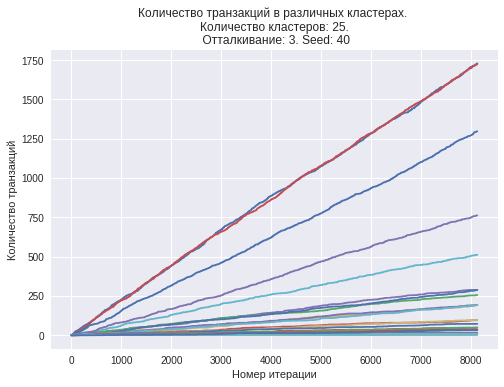

In [262]:
clope.print_history_count(repulsion, seed)

После первой итерации имеем кластеризацию следующего толка (каждая строка -- отдельный кластер, столбец обозначает признак: *e* (съедобный), *p* (несъедобный)). Распределение представлено выше, в таблице.

Как видим, не существует кластеров, в которых одновременно содержится съедобный и несъедобный грибы. Разумеется, это зависит от того, какой параметр отталкивания выбран, но в силу того, что этот параметр один, выбрать его может быть не слишком сложно. Небольшой оптимизацией **GridSearch** можно получить эффективный алгоритм. Этот вопрос обсудим ниже.

Проделаем ещё несколько шагов так, чтобы алгоритм сошёлся:

Итерация:  1 . Номер шага 1000 . Число кластеров:  25
Итерация:  1 . Номер шага 2000 . Число кластеров:  25
Итерация:  1 . Номер шага 3000 . Число кластеров:  25
Итерация:  1 . Номер шага 4000 . Число кластеров:  25
Итерация:  1 . Номер шага 5000 . Число кластеров:  25
Итерация:  1 . Номер шага 6000 . Число кластеров:  25
Итерация:  1 . Номер шага 7000 . Число кластеров:  25
Итерация:  1 . Номер шага 8000 . Число кластеров:  25


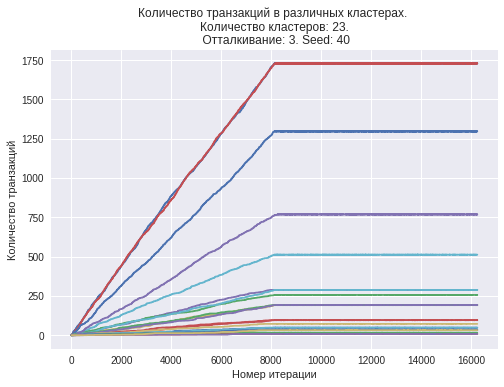

Итерация:  2 . Номер шага 1000 . Число кластеров:  23
Итерация:  2 . Номер шага 2000 . Число кластеров:  23
Итерация:  2 . Номер шага 3000 . Число кластеров:  23
Итерация:  2 . Номер шага 4000 . Число кластеров:  23
Итерация:  2 . Номер шага 5000 . Число кластеров:  23
Итерация:  2 . Номер шага 6000 . Число кластеров:  23
Итерация:  2 . Номер шага 7000 . Число кластеров:  23
Итерация:  2 . Номер шага 8000 . Число кластеров:  23


In [263]:
while clope.next_step(mushrooms, repulsion, noiseLimit) > 0:
    clope.print_history_count(repulsion, seed)

Как видим, алгоритм сходится крайне быстро. Через 2 итерации получаем финальную кластеризацию. 

Заметим, что в первом случае **алгоритм сходится за два прохода**. Т.е. на первом и втором проходах происходит распределение и перераспределение транзакций по кластерам соответственно. На третьем проходе ни одного перемещения между кластерами не происходит. Это говорит о том, что кластеризация закончена. Для иных датасетов, вероятно, алгоритм сходится будет дольше. Но уже после первой итерации будет достигнуто приемлемое качество кластеризации.

Одним из признаков, что уже после первой итерации мы получили достаточно качественную кластеризацию, является график. Так, до 8124 итерации (т.е. первый проход по всем транзакциям) размеры кластеров равномерно росли. На второй итерации оказывается, что размеры кластеров практически не меняются, что говорит о том, что происходят лишь незначительные изменения.

Изменим параметр отталкивания и посмотрим, что получится:

In [265]:
clope = CLOPE(print_step=1000, is_save_history=True, random_seed=seed)
# Начальные данные
repulsion = 2
noiseLimit = 0
# Инициализируем алгоритм
clope.init_clusters(mushrooms, repulsion, noiseLimit)
df = get_count_clusters(clope)
df

Итерация:  0 . Номер шага 1000 . Число кластеров:  16
Итерация:  0 . Номер шага 2000 . Число кластеров:  17
Итерация:  0 . Номер шага 3000 . Число кластеров:  17
Итерация:  0 . Номер шага 4000 . Число кластеров:  17
Итерация:  0 . Номер шага 5000 . Число кластеров:  17
Итерация:  0 . Номер шага 6000 . Число кластеров:  17
Итерация:  0 . Номер шага 7000 . Число кластеров:  18
Итерация:  0 . Номер шага 8000 . Число кластеров:  18


,e,p
0,0,1728
1,144,208
2,1728,0
3,288,0
4,192,0
5,704,256
6,0,1296
7,768,0
8,0,335
9,48,0


Как видим, в этом случае появились кластеры, в которых оказались объекты, относящиеся как к съедобным гриба, так и не к съедобным. Так что, если стоит конкретная задача, то параметр $r$ нужно подбирать очень аккуратно. Об это мы ещё поговорим ниже. Позволи алгоритму сойтись до конца и взглянем на финальные кластеры:

Итерация:  1 . Номер шага 1000 . Число кластеров:  18
Итерация:  1 . Номер шага 2000 . Число кластеров:  18
Итерация:  1 . Номер шага 3000 . Число кластеров:  18
Итерация:  1 . Номер шага 4000 . Число кластеров:  18
Итерация:  1 . Номер шага 5000 . Число кластеров:  18
Итерация:  1 . Номер шага 6000 . Число кластеров:  18
Итерация:  1 . Номер шага 7000 . Число кластеров:  18
Итерация:  1 . Номер шага 8000 . Число кластеров:  18


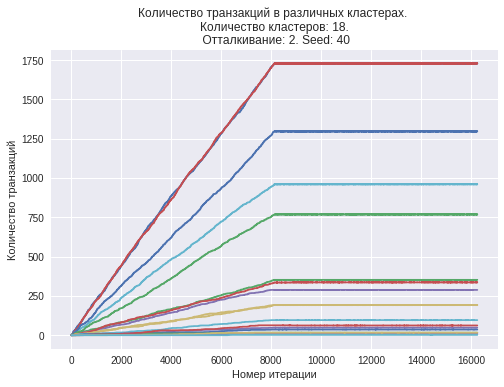

Итерация:  2 . Номер шага 1000 . Число кластеров:  18
Итерация:  2 . Номер шага 2000 . Число кластеров:  18
Итерация:  2 . Номер шага 3000 . Число кластеров:  18
Итерация:  2 . Номер шага 4000 . Число кластеров:  18
Итерация:  2 . Номер шага 5000 . Число кластеров:  18
Итерация:  2 . Номер шага 6000 . Число кластеров:  18
Итерация:  2 . Номер шага 7000 . Число кластеров:  18
Итерация:  2 . Номер шага 8000 . Число кластеров:  18


In [266]:
while clope.next_step(mushrooms, repulsion, noiseLimit) > 0:
    clope.print_history_count(repulsion, seed)

In [267]:
df = get_count_clusters(clope)
df

,e,p
0,0,1728
1,144,208
2,1728,0
3,288,0
4,192,0
5,704,256
6,0,1296
7,768,0
8,0,336
9,48,0



Внимательный читатель мог обратить внимание на кластеры маленькой размерности. Они являют собой транзакции, которые сильно отличаются от остальных. Это может быть расценено как шум. Об этой замечательной особенности  данного алгоритма: детекции шума, - поговорим ниже.

Также, одной из проблем алгоритма является является выбор последовательности обработки транзакций. Или, иными словами: выбор начальной конфигурации алгоритма.

### Кластеризация логов



# Связь с TF-IDF

В исходной статье упоминание про TF-IDF и текстовые данные не фигурирует. При этом, тексты могут рассматриваться как транзакционные объекты. С помощью данного алгоритма можно производить кластеризацию, в т.ч. текстов. 

Для осознания тех выкладок, которые написаны ниже, достаточно понять, что гистограммы в CLOPE -- это частоты объектов, которые присутствуют в кластере. В таком случае легко осознать, что каждый столбец - это величина пропорциональная *tf*:

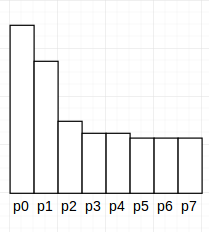

Высота же -- это среднее значение всех частот:

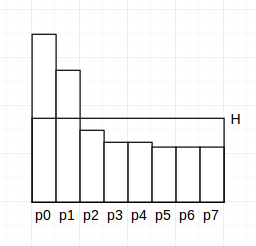

### Формулировка TF-IDF в терминах CLOPE

Пусть каждый документ будет представляться вектором $v$ в [пространстве всех возможных документов](https://en.wikipedia.org/wiki/Vector_space_model). Координатой вектора будем считать веса, заданные согласно $tf-idf$ для каждого отдельно взятого слова.

Пусть есть документы (тексты) $T_i$, где $1 \leq i \leq M$, которые мы будем рассматривать как транзакции. Документ $T_i$ состоит из слов $w_{ij}$ с отношением эквивалентности (в круглых скобках указываются неупорядоченные наборы объектов (слов) с повторениями):

$T_i = (w_{i0}, w_{i1}, w_{iM_i})$

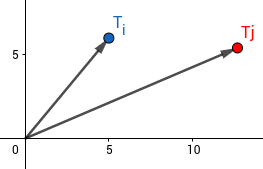

Под кластером $C_i$ будем понимать набор текстов:

$C_j = \{T_{j_0}, T_{j_1}, \cdots, T_{j_L}\}$,

где $L$ - число кластеров на отдельно взятой итерации. Кластеры также можно мыслить как вектор. Следует оговориться, что название "вектор" некорректно и введено лишь для умозрительного представления. Некорректно оно в связи с тем, что сумма векторов, вообще говоря, не есть вектор. По крайней мере, если есть два кластера $C_i$ и $C_j$, которым отвечают два вектора $\vec{v}_i, \vec{v}_j$, сложив их мы не получим вектор, который будет отвечать их объединению $\vec{v}_{ij}$, т.е.:

$\vec{v}_i + \vec{v}_j \neq \vec{v}_{ij}$

Данный факт обусловлен способом построения *tf-idf*.

Введём дополнительное обозначение:

$E_j = \{T_{j}\}$

Кроме того, введём универсальное множество:

$U = \{T_j\}_{j=1}^M$

Понятно, что $1 \leq j \leq M$ для $E$ совпадает с диапазоном изменения переменной для $T$.

Выразим в терминах *CLOPE* метрику *tf-idf*. Уникальные слова для кластера $E_j$ обозначим через $v^{E_j}_i$. Тогда:

$D(E_j) = \{v^{E_j}_0, v^{E_j}_1, \cdots, v^{E_j}_{q_j}\}$,

где $q_j$ - число уникальных объектов в $E_j$. Согласно определению $W$, $S$, которые даны выше:

$W(E_j) = q_j$ - количество уникальных объектов в классе $E_j$

$S(E_j)=\sum_{y \in D(E_j)} Occ(y, E_j)=\sum_{T_k \in E_j} |T_k| = |T_j|$ - площадь гистограммы,

так как $E_j$ состоит ровно из одной транзакции (документа).

Выразим *tf* (отношение числа вхождений некоторого слова $\text{x}$ к общему числу слов кластера (документа) $E_j$):

$tf(x, E_j) = \dfrac{Occ(x, E_j)}{S(E_j)} = \dfrac{Occ(x, E_j)}{|T_j|}$

Рассчитаем среднее значение $tf$ **для какого-нибудь документа**:

$M[tf(x, E_j)] = M\big\lbrack\dfrac{Occ(x, E_j)}{S(E_j)}\big\rbrack  = \dfrac{1}{S(E_j)}M\big\lbrack Occ(x, E_j)\big\rbrack = \dfrac{1}{S(E_j)}\dfrac{\sum_{y \in D(E_j)}Occ(y,E_j)}{W(E_j)} = \dfrac{1}{S(E_j)}\dfrac{S(E_j)}{W(E_j)}=\dfrac{1}{S(E_j)}H(E_j)$

В данном случае $Occ(x, E_j)$ можно считать случайной величиной.

Разделив $M[tf(x, E_j)]$ на количество ненулевых координат в конкретном кластере, получим в точности функционал $G(E_j)$, который предлагается в CLOPE.

### Выводы о связи TF-IDF и CLOPE

Как видим, CLOPE непосредственно связан лишь с *tf* и никак не зависит от *idf*. Для того, чтобы данный алгоритм достаточно качественно работал для полноценных текстов, следует ввести соответствующиие поправки в виде дополнительной нормировки *idf*. В противном случае следует понимать, что кластеризатор будет удовлетворительно работать лишь с короткими текстами, либо документами, в которых присутствует малое количество одинаковых слов, что, как правило, близко к понятию "короткий документ". Возможным примером будет являться задача кластеризации твитов, а также, кластеризация логов какой-нибудь системы. Последняя задача будет рассмотрена ниже.

Действительно, на практике обработка транзакций при помощи CLOPE (здесь понимается под транзакцией не обязательно текст, а набор категориальных признаков), в которых многократно повторяется один и тот же объект, приводит к тому, что алгоритм слишком сильно ведётся на классы с высокочастотными объектами и объединяет их воедино, что вряд ли нужно.

В связи с этим, кластеризации при помощи CLOPE оказывается далека от ожидаемой. Это может происходит по нескольким причинам. Во-первых, как правило, в тексте присутсвует несколько смыслов. CLOPE же берёт в качестве результата "средний смысл", что не есть хорошо и есть предмет серьёзных раздумий в отношении использования данного алгоритма для кластеризации текстов.

С другой стороны, если мы заранее знаем некоторый контекст, в котором написаны документы, мы можем с успехом применить данный алгоритм. Здесь стоит повторно упомянуть задачу про кластеризацию логов. Возвращаясь к задаче о кластеризации твитов, можно также предположить, что информация, которую хотел донести писатель твита, не слишком размыта и, в среднем, находится "около конкретной группы слов".

### IDF (комментарий)

Выразим *idf* (инверсия частоты, с которой некоторое слово встречается в документах коллекции):

$idf(x, U) = \dfrac{Общее\ число\ транзакций}{Число\ кластеров\ (документов)\ E_j \in U ,\ в\ которых\ встречается\ x} = \dfrac{M}{\sum_{k=1}^M W(D(E_k) \cap \{v^{E_j}_i\})}$

Тогда tf-idf имеет вид:

$tf-idf(x, E_j, U) = \dfrac{Occ(x, E_j)}{S(E_j)}\dfrac{M}{\sum_{k=1}^M W(D(E_k) \cap \{v^{E_j}_i\})}$

Такая запись *tf-idf* оказывается довольно сложной. Поэтому преобразуем нормировку в другой вид, путём небольшого допущения. Будем считать частоту слов по всему корпусу документов, вместо указанного выше определения. Тогда запись становится очень простой:

$idf(x, U) = \dfrac{S(U)}{Occ(x, U)}$

Получим:

$tf-idf(x, E_j, U) = \dfrac{Occ(x, E_j)}{S(E_j)}\dfrac{S(U)}{Occ(x, U)}$

Заметим, что $tf$ и $idf$ удобно представляются через условные вероятности, считая $U$ всем пространством:

$tf(x, E_j) = \dfrac{Occ(x, E_j)}{S(E_j)} = p(x|E_j)$

$idf(x, U) = \dfrac{S(U)}{Occ(x, U)} = \dfrac{1}{p(x|U)} = \dfrac{1}{p(x)}$

$tf-idf(x, E_j, U) = \dfrac{Occ(x, E_j)}{S(E_j)}\dfrac{S(U)}{Occ(x, U)} = 
\dfrac{\dfrac{Occ(x, E_j)}{S(E_j)}}{\dfrac{Occ(x, U)}{S(U)}}
= \dfrac{p(x|E_j)}{p(x)}$

Таким образом, мы можем легко модифицировать формулы CLOPE для кластеризации достаточно длинных текстов, в которых есть большое количество повторений.

# Шумовые кластеры, гигантский кластер, величина отталкивания и быстрый поиск оптимального $r$.

Поговорим о кластерах малого размера. Сразу рассмотрим  пример. Построим валидационные кривые для различных параметров отталкивания:

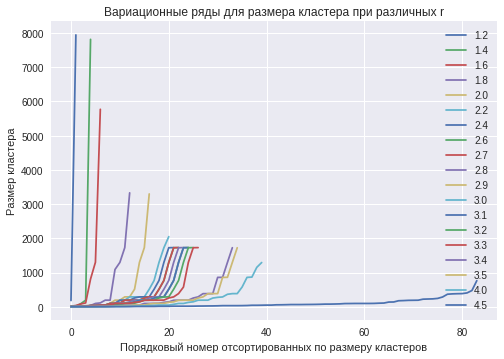

In [22]:
noiseLimit = 0
seed = 42
_, ax = plt.subplots()
linspace = np.hstack((np.arange(1.2, 2.6, 0.2), np.arange(2.6, 3.5, 0.1), np.arange(3.5, 5, 0.5)))
for r in linspace:
    clope = CLOPE(print_step=0, is_save_history=True, random_seed=seed)
    clope.init_clusters(mushrooms, r, noiseLimit)
    df = get_count_clusters(clope)
    df['sum'] = df['e'] + df['p']
    df = df.sort_values(by='sum')
    ax.plot(list(df['sum']))
plt.title('Вариационные ряды для размера кластера при различных r')
plt.xlabel('Порядковый номер отсортированных по размеру кластеров')
plt.ylabel('Размер кластера')
plt.legend(linspace)
plt.show()

Для каждого значения $r$ отсортируем кластеры по количеству элементов в них и построим и на несём значения на график. Это будет вариационным рядом. Очевидно, что при увеличении параметра отталкивания размер максимального кластера уменьшается. А их общее число возрастает. На графике изображены кривые вариационных рядов для различных параметров $r$.

При этом, для определённых значений $r$ наблюдается своего рода фазовый переход ($2.4 \leq r \leq 3.3$). Эту область можно условно назвать областью "стабильности", когда кластеры не объединяются в гигантский кластер и, в то же время, когда они ещё не распадаются на части. Скорее всего такая динамика будет наблюдатся для любых датасетов и это общее фундаментальное свойство алгоритма.

Для маленьких значений $r$ также существуют кластеры малого размера. Именно их можно рассматривать как шум по той причине, что даже при слабом отталкивании они отделились от гиганского кластера. А значит они совершенно непохожи на большую часть примеров. Следовательно, они выбиваются из общего распределения данных.

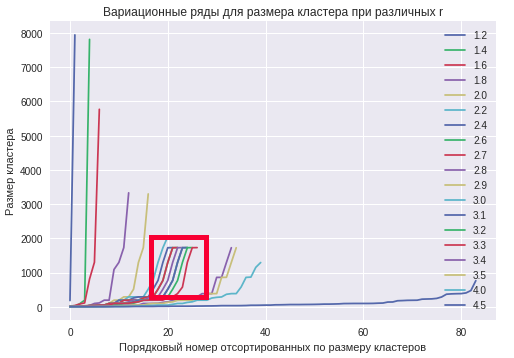

Область фазового перехода выделена выше.

Рассмотрим теперь характер изменения количества кластеров, размер которых $\leq 32$:

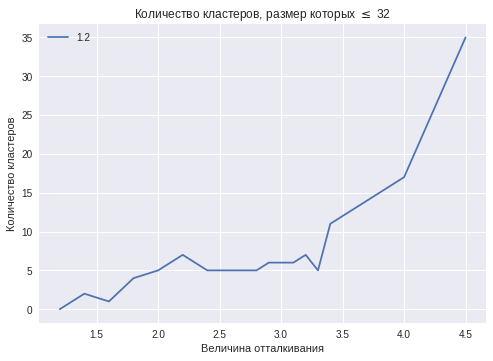

In [33]:
noiseLimit = 0
seed = 42
_, ax = plt.subplots()
linspace = np.hstack((np.arange(1.2, 2.6, 0.2), np.arange(2.6, 3.5, 0.1), np.arange(3.5, 5, 0.5)))
count_clusters = []
for r in linspace:
    clope = CLOPE(print_step=0, is_save_history=True, random_seed=seed)
    clope.init_clusters(mushrooms, r, noiseLimit)
    df = get_count_clusters(clope)
    df['sum'] = df['e'] + df['p']
    df = df.sort_values(by='sum')
    count_clusters.append(df['sum'][df['sum'] <= 32].shape[0])
ax.plot(linspace, count_clusters)
plt.title('Количество кластеров, размер которых $\leq$ 32')
plt.xlabel('Величина отталкивания')
plt.ylabel('Количество кластеров')
plt.legend(linspace)
plt.show()

Как видим, для небольших значений $r$, наблюдается появление шумовых кластеров, о которых мы говорили выше ($r \leq 2.4$ для данного примера). Более формально, будем считать, что любое $r$ до фазового перехода -- малое. Любое $r$ после фазового перехода - большое. Значит, выбрав малое значение $r$ можно выбросить все лишние данные и очистить общее распределение от подозрительных объектов.

Также заметим, что функция, задающая число кластеров монотонна от параметра $r$. А значит можно применять бинарный поиск для нахождения необходимых величин. Здесь можно придраться к тому, что сохраняется общая тенденция монотонности, но при этом есть некоторые флуктуации. Это не страшно, потому как в среднем, тенденция сохраняется.

В данном случае, бинарный поиск можно применять для нескольких вещей:

* поиск $r$ для которого число кластеров малого размера меньше $a$;
* поиск $r$ при котором наблюдается фазовый переход (на некотором интервале будет наблюдаться постоянное ).

Заметим, что поиск фазового перехода может и не сработать, поскольку строгого доказательства описанного поведения функции нет.

Таким образом, мы имеем:

* при варьировании параметра $r$ наблюдается фазовый переход;
* при малых значениях $r$ возможно определять "подозрительные" объекты;
* при малых значениях $r$ будет присутствовать гигантский кластер;
* при больших значениях $r$ все кластеры распадаются на мелкие;
* при помощи бинарного поиска можно найти наиболее подходящее $r$ за $\text{O(log(N))}$, где $N$ - размер сетки, по которой происходит поиск оптимального $r$;

# Задача о кластеризации логов

Сложно сказать, насколько задача о кластеризации логов имеет прикладной смысл. Вероятно, имеет, когда стоит вопрос о их хранении. Этот вопрос рассматривать глубоко не будем.

Итак, возьмём логи [отсюда](http://www.almhuette-raith.at/apache-log/access.log). Выглядят они так:

*151.227.152.48 - - [02/Jul/2014:14:35:55 +0100] "GET / HTTP/1.1" 200 3139 "-" "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.153 Safari/537.36"*

Распарсим их. В качестве объектов кластеризации возьмём пути, по которам запрашивались файлы:

In [269]:
f = open('access.log', 'r')
log = [item for item in f.readlines()]

# 207 уникальных ip
# Все таймзоны одинаковые
# Дни месяцев брать не будем

date = np.array([item.split()[3][1:].split('/') for item in log])

ip = [item.split()[0] + '_0' for item in log]
month = [month + '_1' for month in date[:, 1]]
year = [item.split(':')[0] + '_2' for item in date[:, 2]]
hour = [item.split(':')[1] + '_3' for item in date[:, 2]]
type_of_query = [item.split()[5] + '_4' for item in log]
proto = [item.split()[7] + '_5' for item in log]
code = [item.split()[8] + '_6' for item in log]
browse = [item.split()[11] + '_7' for item in log]
path = [[path for path in item.split()[6].split('/') if len(path) != 0] for item in log]

# trasactions = {i: transact for i, transact in enumerate(np.transpose(np.vstack([ip, month, year, hour, type_of_query, proto, code, browse])))}
trasactions = {i: transact for i, transact in enumerate(np.transpose(path))}

# np.unique(np.array([item.split()[6].split('/')[-1] for item path[:10] log]))
# file_name = [item.split()[6].split('/')[-1] for item in log]

path[:10]

[[],
 ['css', 'main.css'],
 ['js', 'vendor', 'modernizr-2.6.2.min.js'],
 ['js', 'plugins.js'],
 ['js', 'main.js'],
 ['img', 'stanmore-logo.gif'],
 ['img', 'houses.jpg'],
 ['img', 'Fascias-division.jpg'],
 ['img', 'Dry-Lining-division.jpg'],
 ['img', 'Metal-Work-division.jpg']]

Также, для читателей я выделил несколько других объектов: даты, протокол и т.п. Возможно, кто-то захочет с ними поиграться.

Зададим параметры:

In [286]:
noiseLimit = 0
seed = 41
r = 1.5

Инициализируем алгоритм. Печать отладочной информации будет происходить каждые `print_step=1000` транзакций. Также, будет сохраняться история размеров кластеров `is_save_history=True`. `NoiseLimit=0` означает, что перед началом итерации, а также после её завершения все кластеры, размер которых $\geq 0$ будут удалены. А транзакции, попавшие в эти кластеры, соответственно, будут считаться шумовыми. Если `noiseLimit=-1`, то порог будет выставляться автоматически:

Итерация:  0 . Номер шага 1000 . Число кластеров:  83
Итерация:  0 . Номер шага 2000 . Число кластеров:  111
Итерация:  0 . Номер шага 3000 . Число кластеров:  126
Итерация:  0 . Номер шага 4000 . Число кластеров:  136
Итерация:  0 . Номер шага 5000 . Число кластеров:  148
Итерация:  0 . Номер шага 6000 . Число кластеров:  161
Итерация:  0 . Номер шага 7000 . Число кластеров:  168
Итерация:  0 . Номер шага 8000 . Число кластеров:  175
Итерация:  0 . Номер шага 9000 . Число кластеров:  182
Итерация:  0 . Номер шага 10000 . Число кластеров:  190
Итерация:  0 . Номер шага 11000 . Число кластеров:  196
Итерация:  0 . Номер шага 12000 . Число кластеров:  202
Итерация:  0 . Номер шага 13000 . Число кластеров:  208
Итерация:  0 . Номер шага 14000 . Число кластеров:  215
Итерация:  0 . Номер шага 15000 . Число кластеров:  220
Итерация:  0 . Номер шага 16000 . Число кластеров:  227
Итерация:  0 . Номер шага 17000 . Число кластеров:  234
Итерация:  0 . Номер шага 18000 . Число кластеров:  239
Ит

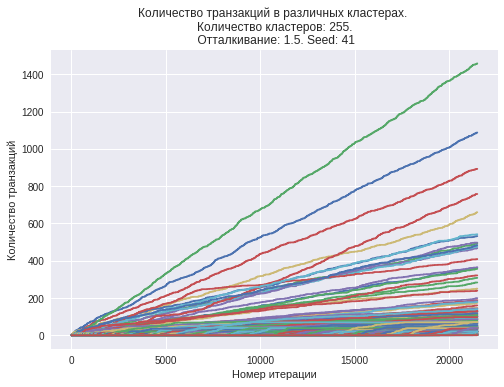

In [287]:
clope = CLOPE(print_step=1000, is_save_history=True, random_seed=seed)
clope.init_clusters(trasactions, r, noiseLimit)
clope.print_history_count(r, seed)

Выведем пример транзакций, попавших в один кластер:

In [293]:
count = 0
cl = []
for transact_ind in clope.transaction:
    cluster = clope.transaction[transact_ind]
    if cluster == 180:
        cl.append(trasactions[transact_ind])
        count += 1
    if count > 20:
        break

print(cl[:10])

[['perch', 'resources', '1.jpg'], ['perch', 'resources', 'exterior-thumb@2x.jpg'], ['perch', 'resources', '03-8.jpg'], ['perch', 'resources', '04-3.jpg'], ['perch', 'resources', 'facade-thumb@2x.jpg'], ['perch', 'resources', 'hill.jpg'], ['perch', 'resources', 'img6721.jpg'], ['perch', 'resources', '01-20.jpg'], ['perch', 'resources', 'wilmottdixonhousing.jpg'], ['perch', 'resources', 'wilmottdixonhousing.jpg']]


На каждой итерации можно выставлять свой порог `noiseLimit`. Попробуем дообучить наш кластеризатор:

Итерация:  1 . Номер шага 1000 . Число кластеров:  255
Итерация:  1 . Номер шага 2000 . Число кластеров:  255
Итерация:  1 . Номер шага 3000 . Число кластеров:  255
Итерация:  1 . Номер шага 4000 . Число кластеров:  255
Итерация:  1 . Номер шага 5000 . Число кластеров:  260
Итерация:  1 . Номер шага 6000 . Число кластеров:  263
Итерация:  1 . Номер шага 7000 . Число кластеров:  268
Итерация:  1 . Номер шага 8000 . Число кластеров:  275
Итерация:  1 . Номер шага 9000 . Число кластеров:  276
Итерация:  1 . Номер шага 10000 . Число кластеров:  278
Итерация:  1 . Номер шага 11000 . Число кластеров:  279
Итерация:  1 . Номер шага 12000 . Число кластеров:  280
Итерация:  1 . Номер шага 13000 . Число кластеров:  281
Итерация:  1 . Номер шага 14000 . Число кластеров:  282
Итерация:  1 . Номер шага 15000 . Число кластеров:  286
Итерация:  1 . Номер шага 16000 . Число кластеров:  292
Итерация:  1 . Номер шага 17000 . Число кластеров:  297
Итерация:  1 . Номер шага 18000 . Число кластеров:  303
И

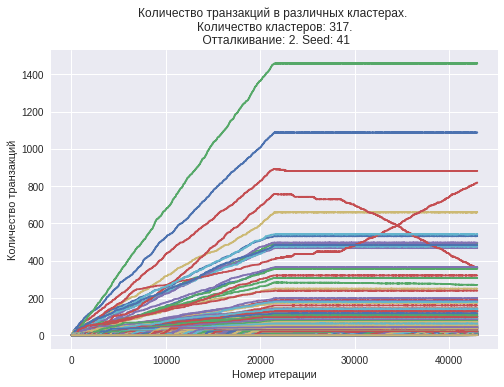

Итерация:  2 . Номер шага 1000 . Число кластеров:  317
Итерация:  2 . Номер шага 2000 . Число кластеров:  320
Итерация:  2 . Номер шага 3000 . Число кластеров:  322
Итерация:  2 . Номер шага 4000 . Число кластеров:  323
Итерация:  2 . Номер шага 5000 . Число кластеров:  324
Итерация:  2 . Номер шага 6000 . Число кластеров:  325
Итерация:  2 . Номер шага 7000 . Число кластеров:  325
Итерация:  2 . Номер шага 8000 . Число кластеров:  325
Итерация:  2 . Номер шага 9000 . Число кластеров:  325
Итерация:  2 . Номер шага 10000 . Число кластеров:  325
Итерация:  2 . Номер шага 11000 . Число кластеров:  325
Итерация:  2 . Номер шага 12000 . Число кластеров:  325
Итерация:  2 . Номер шага 13000 . Число кластеров:  325
Итерация:  2 . Номер шага 14000 . Число кластеров:  325
Итерация:  2 . Номер шага 15000 . Число кластеров:  325
Итерация:  2 . Номер шага 16000 . Число кластеров:  325
Итерация:  2 . Номер шага 17000 . Число кластеров:  325
Итерация:  2 . Номер шага 18000 . Число кластеров:  325
И

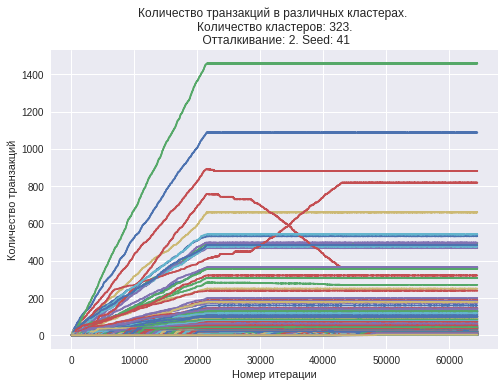

Итерация:  3 . Номер шага 1000 . Число кластеров:  323
Итерация:  3 . Номер шага 2000 . Число кластеров:  323
Итерация:  3 . Номер шага 3000 . Число кластеров:  323
Итерация:  3 . Номер шага 4000 . Число кластеров:  327
Итерация:  3 . Номер шага 5000 . Число кластеров:  328
Итерация:  3 . Номер шага 6000 . Число кластеров:  328
Итерация:  3 . Номер шага 7000 . Число кластеров:  328
Итерация:  3 . Номер шага 8000 . Число кластеров:  328
Итерация:  3 . Номер шага 9000 . Число кластеров:  332
Итерация:  3 . Номер шага 10000 . Число кластеров:  333
Итерация:  3 . Номер шага 11000 . Число кластеров:  336
Итерация:  3 . Номер шага 12000 . Число кластеров:  341
Итерация:  3 . Номер шага 13000 . Число кластеров:  345
Итерация:  3 . Номер шага 14000 . Число кластеров:  349
Итерация:  3 . Номер шага 15000 . Число кластеров:  349
Итерация:  3 . Номер шага 16000 . Число кластеров:  351
Итерация:  3 . Номер шага 17000 . Число кластеров:  351
Итерация:  3 . Номер шага 18000 . Число кластеров:  351
И

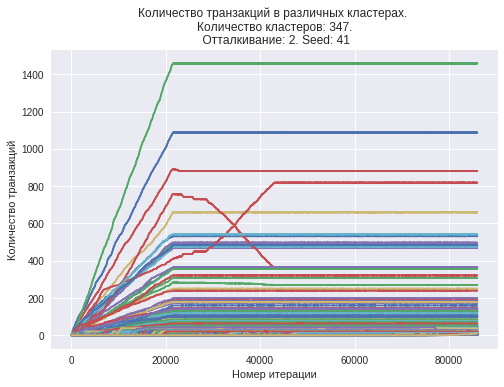

Итерация:  4 . Номер шага 1000 . Число кластеров:  347
Итерация:  4 . Номер шага 2000 . Число кластеров:  347
Итерация:  4 . Номер шага 3000 . Число кластеров:  347
Итерация:  4 . Номер шага 4000 . Число кластеров:  347
Итерация:  4 . Номер шага 5000 . Число кластеров:  347
Итерация:  4 . Номер шага 6000 . Число кластеров:  347
Итерация:  4 . Номер шага 7000 . Число кластеров:  347
Итерация:  4 . Номер шага 8000 . Число кластеров:  347
Итерация:  4 . Номер шага 9000 . Число кластеров:  347
Итерация:  4 . Номер шага 10000 . Число кластеров:  349
Итерация:  4 . Номер шага 11000 . Число кластеров:  352
Итерация:  4 . Номер шага 12000 . Число кластеров:  352
Итерация:  4 . Номер шага 13000 . Число кластеров:  352
Итерация:  4 . Номер шага 14000 . Число кластеров:  352
Итерация:  4 . Номер шага 15000 . Число кластеров:  352
Итерация:  4 . Номер шага 16000 . Число кластеров:  352
Итерация:  4 . Номер шага 17000 . Число кластеров:  352
Итерация:  4 . Номер шага 18000 . Число кластеров:  352
И

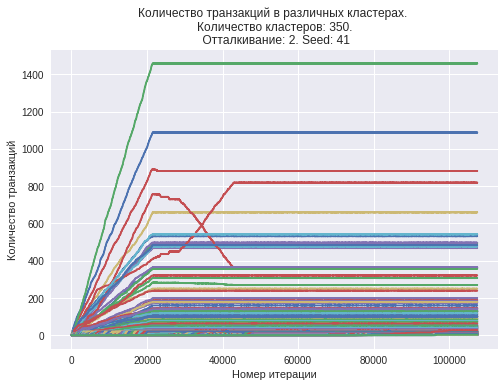

Итерация:  5 . Номер шага 1000 . Число кластеров:  350
Итерация:  5 . Номер шага 2000 . Число кластеров:  351
Итерация:  5 . Номер шага 3000 . Число кластеров:  354
Итерация:  5 . Номер шага 4000 . Число кластеров:  354
Итерация:  5 . Номер шага 5000 . Число кластеров:  355
Итерация:  5 . Номер шага 6000 . Число кластеров:  355
Итерация:  5 . Номер шага 7000 . Число кластеров:  355
Итерация:  5 . Номер шага 8000 . Число кластеров:  355
Итерация:  5 . Номер шага 9000 . Число кластеров:  355
Итерация:  5 . Номер шага 10000 . Число кластеров:  355
Итерация:  5 . Номер шага 11000 . Число кластеров:  355
Итерация:  5 . Номер шага 12000 . Число кластеров:  355
Итерация:  5 . Номер шага 13000 . Число кластеров:  355
Итерация:  5 . Номер шага 14000 . Число кластеров:  355
Итерация:  5 . Номер шага 15000 . Число кластеров:  355
Итерация:  5 . Номер шага 16000 . Число кластеров:  355
Итерация:  5 . Номер шага 17000 . Число кластеров:  355
Итерация:  5 . Номер шага 18000 . Число кластеров:  355
И

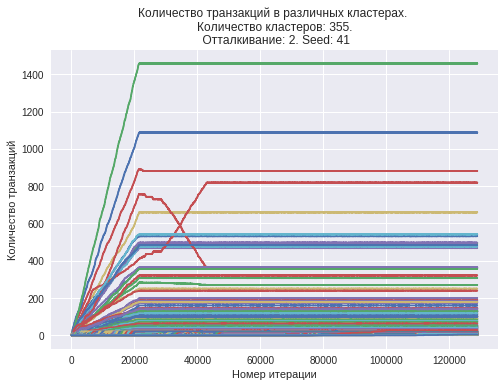

Итерация:  6 . Номер шага 1000 . Число кластеров:  355
Итерация:  6 . Номер шага 2000 . Число кластеров:  355
Итерация:  6 . Номер шага 3000 . Число кластеров:  355
Итерация:  6 . Номер шага 4000 . Число кластеров:  355
Итерация:  6 . Номер шага 5000 . Число кластеров:  355
Итерация:  6 . Номер шага 6000 . Число кластеров:  355
Итерация:  6 . Номер шага 7000 . Число кластеров:  355
Итерация:  6 . Номер шага 8000 . Число кластеров:  355
Итерация:  6 . Номер шага 9000 . Число кластеров:  355
Итерация:  6 . Номер шага 10000 . Число кластеров:  355
Итерация:  6 . Номер шага 11000 . Число кластеров:  355
Итерация:  6 . Номер шага 12000 . Число кластеров:  355
Итерация:  6 . Номер шага 13000 . Число кластеров:  355
Итерация:  6 . Номер шага 14000 . Число кластеров:  355
Итерация:  6 . Номер шага 15000 . Число кластеров:  355
Итерация:  6 . Номер шага 16000 . Число кластеров:  355
Итерация:  6 . Номер шага 17000 . Число кластеров:  355
Итерация:  6 . Номер шага 18000 . Число кластеров:  355
И

In [ ]:
while clope.next_step(trasactions, repulsion, noiseLimit) > 0:
    clope.print_history_count(repulsion, seed)

Заметим, что в отличие от первого примера, здесь число кластеров на второй и последующих итерациях заметно изменилось. Также и количество перемещений между кластерами оказывается значительным.

Сохранение истории может отжирать довольно большое количество памяти. Поэтому, этот флаг следует использовать лишь для небольших датасетов.

Для того, чтобы определить к какому из кластеров принадлежит та или иная транзакция, необходимо проделать следующее упражнение:

In [ ]:
clope.transaction[0]

# Ограничение по числу кластеров

Во многих задачах мы работаем с огромными массивами данных. В данном случае, CLOPE может начать вести себя не очень хорошо. В частости, время его работы очень сильно возрастает. А число кластеров экспоненциально увеличивается. В таком случае имеет смысл ограничивать количество кластеров. Но следует понимать, что разбиение станет неоптимальным. В частности, приращение значения целевой функции может стать отрицательным.

# Оценка сложности

Оценим вычислительную сложность алгоритма. Пусть средняя длина транзакции равна $A$, общее число транзакций $M$, максимально возможное число кластеров $q$. Временная сложность одной итерации равна O(NAq), показывающая, что скорость работы алгоритма растет линейно с ростом кластеров и размера таблицы.

# Обработка вещественных признаков

Встаёт закономерный вопрос: можно ли при помощи данного алгоритма обрабатывать числовые признаки, а не тольк категориальные? Коль скоро алгоритм, по своей природе основан на отношении эквивалентности, необходимо ввести для числовых признаков классы эквивалентности. Говоря более простым языком объединить по каким-либо способом числовые признаки в группы. Самый простой и очевидный способ сделать это - построить гистограмму.

Пусть у нас есть числовая переменная $x$, значения которой отвечают нормальному закону распределения. Нам также необходимо знать диапазон значений, в котором изменяется $x$. В таком случае, легко разбить значения нашей переменной на интервалы. Оптимальное количество интервалов можно выбирать [основываясь на схеме испытаний бернулли](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B0%D0%B2%D0%B8%D0%BB%D0%BE_%D0%A1%D1%82%D1%91%D1%80%D0%B4%D0%B6%D0%B5%D1%81%D0%B0): $bins=[log_2(N)]+1$, где $bins$ - число интервалов. Теперь, как было в примерах выше, каждую группу значений мы можем обозначить за некоторую величину и считать неотличимыми, рассматривая как категориальный признак.

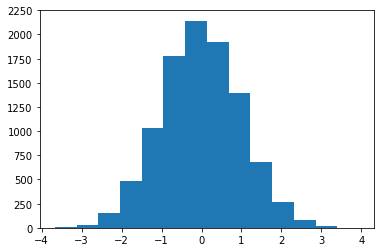

In [7]:
from numpy.random import normal
import numpy as np
import matplotlib.pyplot as plt

count_features = 10000
mean = 0
var = 1
x = normal(loc=mean, scale=var, size=(count_features))
intervals = plt.hist(x, bins=np.uint(np.log2(count_features)+1))
plt.show()

Мы легко получим интервалы из переменной `intervals`:

In [8]:
for i in range(1, len(intervals[1])):
    print('Интервал', i, ':', intervals[1][i-1], intervals[1][i])

Интервал 1 : -3.66915400823 -3.12545870179
Интервал 2 : -3.12545870179 -2.58176339535
Интервал 3 : -2.58176339535 -2.03806808891
Интервал 4 : -2.03806808891 -1.49437278247
Интервал 5 : -1.49437278247 -0.950677476034
Интервал 6 : -0.950677476034 -0.406982169594
Интервал 7 : -0.406982169594 0.136713136847
Интервал 8 : 0.136713136847 0.680408443287
Интервал 9 : 0.680408443287 1.22410374973
Интервал 10 : 1.22410374973 1.76779905617
Интервал 11 : 1.76779905617 2.31149436261
Интервал 12 : 2.31149436261 2.85518966905
Интервал 13 : 2.85518966905 3.39888497549
Интервал 14 : 3.39888497549 3.94258028193


# Выводы. Плюсы и минусы алгоритма

К сожалению, осветить всё то, что хочется в одной статье проблематично. Посколько получается огромное количество материалов. Резюмируя всё вышесказанное, можно заключить:

**Плюсы:**

* Временная сложность. Глобальный критерий оптимизации
* Быстрая сходимость
* Параметризация по $r$
* Качество кластеризации (согласно заявлениям авторов)
* Возможность выделять шумы

**Минусы**

* Выбор начального состояния (начальный порядок объектов)
* Лавионообразное появление кластеров при большом количестве транзакций
* Долгое выполнение при большом числе кластеров
* Большие кластеры являются сильно притягивают к себе новые объекты
* Проблема с дообучением при заданном априори разбиении
* В авторском алгоритме отсутствует упоминание про взвешивание
* Наличие нескольких одинаковых объектов в транзакции может сильно повлиять на результат
* Отсутствиие аппарата, позволяющего учитывать ранговые признаки. А значит невозможно работать с временными рядами

Если статья окажется интересной сообществу, можно будет показать, как с помощью этого алгоритма можно кластеризовать группы вконтакте. Кроме того, у данного метода есть большой потенциал для распараллеливания, что возлагает на него большие надежды.

# Используемая литература

1. [CLOPE: A Fast and Effective Clustering Algorithm for Transactional Data. Yiling Yang, Xudong Guan, Jinyuan You, 2002](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.13.7142&rep=rep1&type=pdf)
2. [Кластеризация категорийных данных: масштабируемый алгоритм CLOPE](https://basegroup.ru/community/articles/clope)
3. [Один способ кластеризации данных с неполным обучением и его оценка. Бильгаева Л.П., Самбялов З.Г.](https://www.fundamental-research.ru/pdf/2013/11-8/33381.pdf)
